In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
# from statsmodels import imputation 
from statsmodels.imputation import mice
data = pd.read_csv('final4a.csv')
import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np

from collections import defaultdict
import estimator 


In [2]:
#This code block has been commented out but it was essentially importing the HW2 files. An alternative approach has been 
#used to import the HW2 files to allow for easier access via GitHub.


# import importlib.util
# import pathlib
# import os

# curr_dir = os.path.join(pathlib.Path().resolve(), "..\..\hw2-YusraAft\estimator.py")
# print(curr_dir)
# spec=importlib.util.spec_from_file_location("estimator",curr_dir)
  
# # creates a new module based on spec
# estimator = importlib.util.module_from_spec(spec)
# spec.loader.exec_module(estimator)


In [3]:
data

,Unnamed: 0,schlcode,c_size,c_boys,c_girls,c_numcl,c_pik,c_status,c_leom,c_tip,...,nmath_n,verb_n,flverb_n,nverb_n,impute,nverb_m,nmath_m,tip_s,townid,tipuach
0,0,11005,35,12,23,9,1,2,1,5.0,...,35.0,65.770000,17.100000,35.0,0,NaN,NaN,24.0,26104.0,24
1,1,11006,54,23,31,12,2,2,1,7.0,...,48.0,61.406532,30.595919,49.0,0,NaN,NaN,38.0,26104.0,38
2,2,11006,54,23,31,12,2,2,1,7.0,...,48.0,61.406532,30.595919,49.0,0,NaN,NaN,38.0,26104.0,38
3,3,11009,38,15,23,6,1,2,1,1.0,...,37.0,78.370000,13.200000,38.0,0,NaN,NaN,6.0,4622.0,6
4,4,11010,73,40,33,15,1,1,1,NaN,...,72.0,74.485000,20.000000,70.0,0,NaN,NaN,3.0,30007.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2054,2054,61359,133,73,60,14,1,1,1,NaN,...,130.0,73.947680,14.729457,129.0,0,NaN,NaN,3.0,703.0,3
2055,2055,61363,29,16,13,7,1,1,1,NaN,...,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,22
2056,2056,61364,66,41,25,15,1,1,1,NaN,...,59.0,80.966250,0.000000,56.0,0,NaN,NaN,NaN,NaN,0
2057,2057,61364,66,41,25,15,1,1,1,NaN,...,59.0,80.966250,0.000000,56.0,0,NaN,NaN,NaN,NaN,0


In [4]:
#We want to select only the columns that correspond to the variables I am interested in studying the causal relationship of
#Here I have taken the feedback and tried schoolcode and townid.

cols = ["classize", "townid", "schlcode", "avgmath", "tipuach"]
data = data[cols]
print(data)


      classize   townid  schlcode  avgmath  tipuach
0           35  26104.0     11005    64.94       24
1           27  26104.0     11006    56.80       38
2           27  26104.0     11006    56.91       38
3           38   4622.0     11009    76.70        6
4           37  30007.0     11010    61.40        3
...        ...      ...       ...      ...      ...
2054        32    703.0     61359    75.65        3
2055        21      NaN     61363    63.00       22
2056        33      NaN     61364    65.23        0
2057        33      NaN     61364    72.03        0
2058        20      NaN     61365    49.00       60

[2059 rows x 5 columns]


In [5]:
#This shows the amount of missing data that currently exists in the original data files

data.isna().sum()


classize     0
townid      11
schlcode     0
avgmath      4
tipuach      0
dtype: int64

In [6]:
#Initializing a new dataframe 

df = pd.DataFrame(data)
df.dropna()
df

,classize,townid,schlcode,avgmath,tipuach
0,35,26104.0,11005,64.94,24
1,27,26104.0,11006,56.80,38
2,27,26104.0,11006,56.91,38
3,38,4622.0,11009,76.70,6
4,37,30007.0,11010,61.40,3
...,...,...,...,...,...
2054,32,703.0,61359,75.65,3
2055,21,NaN,61363,63.00,22
2056,33,NaN,61364,65.23,0
2057,33,NaN,61364,72.03,0


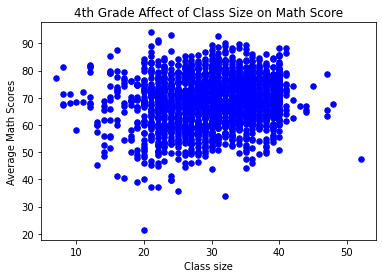

In [7]:
#This is irrelevant to the actual code and simply is there to see a graph of the classize and avgmath scores

x = df['classize']
y = df ['avgmath']

plt.scatter(x, y, color= "blue",
            s=30)
plt.xlabel('Class size')
plt.ylabel('Average Math Scores')
plt.title("4th Grade Affect of Class Size on Math Score")
plt.show()

In [8]:
#Here we actually define what our outcome, confounders and formula will be for the Backdoor Estimator. As per the feedback 
#this has been adjusted to use townid, tipuach and schoolcode.

outcome ="avgmath"
confounders = ["schlcode", "townid", "tipuach"]
formula = outcome + " ~ + {}".format(" + ".join(confounders))



In [9]:
#Here we calculate backdoor estimator but we do with MICE so that we can account for missing data. The imp.next_sample() 
#generates new data(imputations) for missing data each time. Hence, we are doing this 10 times to take an average of 
#backdoor estimator on each of the generated samples to allow for more robust findings. The standard deviation is also 
#calculated as an extra means of evaluating the backdoor estimator results. Robust meaning less likely to have occurred by 
#chance and perhaps showing the actual relation between the presented variables. 

#estimator.backdoorfeedback is different here as it is adjusted to take only two class sizes 25 and 52.


main_df = df

imp2 = mice.MICEData(main_df)
dict_estimators = defaultdict(list)
for j in range(10):
    df = imp2.next_sample()
    array_ = estimator.backdoorfeedback(df, confounders=confounders,intervention="classize", outcome="avgmath")
#     print(len(array_))
    for array_estimate in range(len(array_)):
        dict_estimators[array_estimate].append(array_[array_estimate])
    
        
ret = []
stds= []
keys = sorted(dict_estimators.keys())
for key in keys:
    backdoor_estimates = dict_estimators[key]
    avg = np.mean(backdoor_estimates)
    std = np.std(backdoor_estimates)
    stds.append(std)
    ret.append(avg)

# ret = np.array(ret)
ret_str = [float("{:.3f}".format(r)) for r in ret]
print(f'Back Door Estimates: {ret_str}')


print(f'Standard Deviations: {stds}')

Back Door Estimates: [68.005, 68.984]
Standard Deviations: [0.022301763420198743, 0.00840786232846974]


In [10]:

#This is the place we actually run the estimator.bootstrap to see the uncertainty of the data. We have combined this wiht 
#mice here to allow for viewing the uncertainty that mice would provide as that is the method being used for 
#missing data. This has also bee repeated 1 total of 100 times due to it being 10*10 to allow for more robust findings. 


def backdoor_mice(data, n_mice=10):
    imp = mice.MICEData(data)#datset with no missing data
    dict_mice = defaultdict(list)
    for j in range(n_mice):
        df = imp.next_sample()
        array_ = estimator.backdoorfeedback(df, confounders=confounders,intervention="classize", outcome="avgmath")
        for array_estimate in range(len(array_)):
            dict_mice[array_estimate].append(array_[array_estimate])
    ret = []
    keys = sorted(dict_mice.keys())
   
    for key in keys:
        backdoor_estimates = dict_mice[key]
        avg = np.mean(backdoor_estimates)
        ret.append(avg)
    return ret
# backdoor_mice(main_df)
estimator.bootstrap(main_df, backdoor_mice, n=10, n_mice=10) #n_mice*n = number of times backdoor mice runs


    
    

array([[67.64073611, 68.87374232],
       [68.47391048, 69.30031099]])

In [11]:
#produces complete datasets
# imp.next_sample()

In [25]:
#imp.next_sample() #genearates new data(imputations) for missing data each time